In [1]:
# imports
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import os
from scipy.stats import sem, zscore
from sklearn.decomposition import PCA
from tslearn.clustering import TimeSeriesKMeans
from scipy.stats import ttest_ind_from_stats
import statsmodels.stats.multitest as smm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from fcutils.plot.elements import plot_mean_and_error
from fcutils.plot.figure import calc_nrows_ncols
sys.path.append("./")

fld = Path(os.getcwd()).parent
sys.path.append(str(fld))

from electrophysiology.utils import load_rec_data, get_locomotion_onset_times

# cache = Path("/Users/federicoclaudi/Desktop/APA")
cache = Path("/Users/federicoclaudi/Desktop/neuropixels")
tracking_files = cache.glob("*.parquet")
recordings = [f.stem for f in tracking_files if not f.stem.startswith("._")]
len(recordings)



19

### Load all units

In [2]:
DeltaT = 1000 # time before/after frame


units_traces = {}
speed_traces = []  # for each trial store all speed traces
n_trials_per_rec = dict(rec=[], tot=[], left=[], right=[])
for i, rec in enumerate(recordings):
    print(f"Doing {i+1} of {len(recordings)}")
    tracking, units = load_rec_data(cache, rec)
    units_names = units.columns

    if len(units.columns) == 0:
        print("     skipping, no units")
        continue

    # get movement onset timings
    right_fl_onsets = get_locomotion_onset_times(tracking, "right_fl", cutoff=1500)
    left_fl_onsets = get_locomotion_onset_times(tracking, "left_fl", cutoff=1500)
    l, r= len(left_fl_onsets), len(right_fl_onsets)
    if r == 0 or l == 0:
        print("     skipping, not enough trials")
        continue
    print(f"    found {r} and {l} R/L trials.")
    n_trials_per_rec["rec"].append(rec)
    n_trials_per_rec["tot"].append(l+r)
    n_trials_per_rec["left"].append(l)
    n_trials_per_rec["right"].append(r)
    

    for j, name in enumerate(units_names):
        alltraces = []
        for (paw, timepoints) in  zip(("right_fl", "left_fl"), (right_fl_onsets, left_fl_onsets)):
                # store unit's firing rate trace
                traces = []
                for frame in timepoints:
                    trace = units[name].values[frame-DeltaT:frame+DeltaT]
                    if len(trace) < 2*DeltaT:
                        continue
                    traces.append(trace)

                    # store tracking
                    if j == 0:
                        speed_traces.append(
                            tracking[paw+"_v"].values[frame-DeltaT:frame+DeltaT]
                        )
                alltraces.extend(traces)
        units_traces[rec+"_"+name] = alltraces
        

Doing 1 of 19
    found 28 and 19 R/L trials.
Doing 2 of 19
     skipping, no units
Doing 3 of 19
    found 12 and 5 R/L trials.
Doing 4 of 19
    found 44 and 34 R/L trials.
Doing 5 of 19
    found 25 and 13 R/L trials.
Doing 6 of 19
    found 17 and 11 R/L trials.
Doing 7 of 19
     skipping, no units
Doing 8 of 19
     skipping, no units
Doing 9 of 19
    found 64 and 36 R/L trials.
Doing 10 of 19
     skipping, no units
Doing 11 of 19
     skipping, no units
Doing 12 of 19
    found 32 and 20 R/L trials.
Doing 13 of 19
    found 7 and 5 R/L trials.
Doing 14 of 19
    found 32 and 25 R/L trials.
Doing 15 of 19
    found 12 and 9 R/L trials.
Doing 16 of 19
    found 17 and 19 R/L trials.
Doing 17 of 19
    found 17 and 10 R/L trials.
Doing 18 of 19
    found 37 and 38 R/L trials.
Doing 19 of 19
    found 14 and 12 R/L trials.


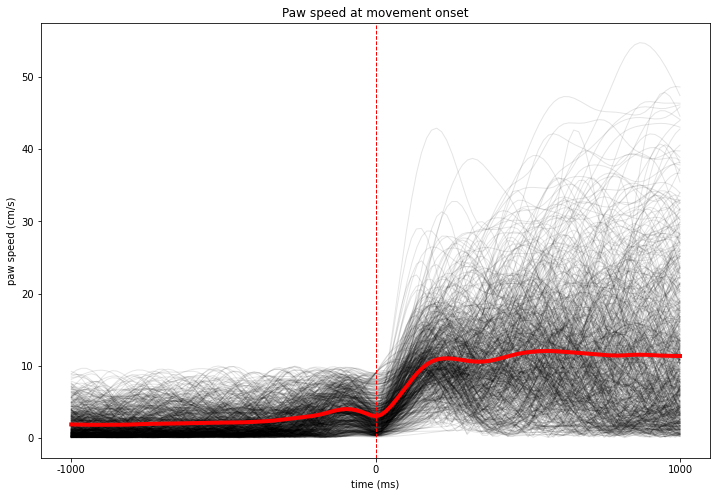

In [3]:
# plot all paw speed traces
f, ax = plt.subplots(figsize=(12, 8))
for t in speed_traces:
    ax.plot(t, lw=1, color="black", alpha=.1)

mu = np.mean(np.vstack(speed_traces), 0)
ax.plot(mu, lw=4, color="red")
ax.axvline(DeltaT, lw=1, color="red", ls="--")
_ = ax.set(xlabel="time (ms)", xticks=[0, DeltaT, 2*DeltaT], xticklabels=[-DeltaT, 0, DeltaT], ylabel="paw speed (cm/s)", title="Paw speed at movement onset")

## Numbers
TODO
Get number of units, mice, recordings...
Also add the number of trials per recording and the L/R

In [4]:
nmice = len(set([r.split("_")[2] for r in n_trials_per_rec["rec"]]))
n_recs = len(n_trials_per_rec["rec"])
n_units = len(units_traces.keys())
tot_n_trials = len(speed_traces)

print(f"""
Performed {n_recs} recording across {nmice} animals.
Total of {n_units} neurons recorded, {tot_n_trials} trials total.
""")

nums = pd.DataFrame(n_trials_per_rec)
nums = nums.drop("rec", axis="columns")

print("\nMean number of trials per recording")
print(nums.mean())
print("\nStd number of trials per recording")
print(nums.std())
print("\nIn total:")
print(nums.sum())



Performed 14 recording across 4 animals.
Total of 304 neurons recorded, 614 trials total.


Mean number of trials per recording
tot      43.857143
left     18.285714
right    25.571429
dtype: float64

Std number of trials per recording
tot      25.937372
left     11.186727
right    15.450737
dtype: float64

In total:
tot      614
left     256
right    358
dtype: int64


## PSTH analysis

1. Compute the PSTH (average time-aligned trace) of each unit by taking the average of traces aligned to movement onset. z-score each PSTH, and stack em in a matrix Z.


2. Use the "elbow method" to estimate the number of clusters required. Briefly, do Kmeans clustering with different numbers of clusters. The more clusters the less the error (SSE). Find an elbow in the plot of SSE vs num clusters; similar to this: Based on this paper: https://elifesciences.org/articles/70129#s4)

3. Cluster using KMeans for time-series data based on the number of clusters found with the previous step

#### Compute PSTH
And plto all PSTH in a heatmap.

Z: (304, 2000)


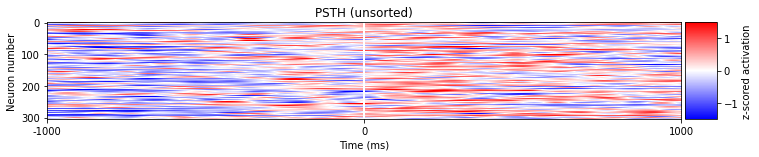

In [5]:
Z = zscore(np.vstack(
    [np.mean(x, 0) for x in units_traces.values()]
), 1)
print(f"Z: {Z.shape}")

# plot PSTH as heatmap
f, ax = plt.subplots(figsize=(12, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(Z, cmap="bwr", clim=[-1.5, 1.5])
f.colorbar(im, cax=cax, orientation='vertical', label="z-scored activation")
ax.axvline(DeltaT, lw=2, color="white")
_ = ax.set(xlabel="Time (ms)", xticks=[0, DeltaT, 2*DeltaT], xticklabels=[-DeltaT, 0, DeltaT], ylabel="Neuron number", title="PSTH (unsorted)")


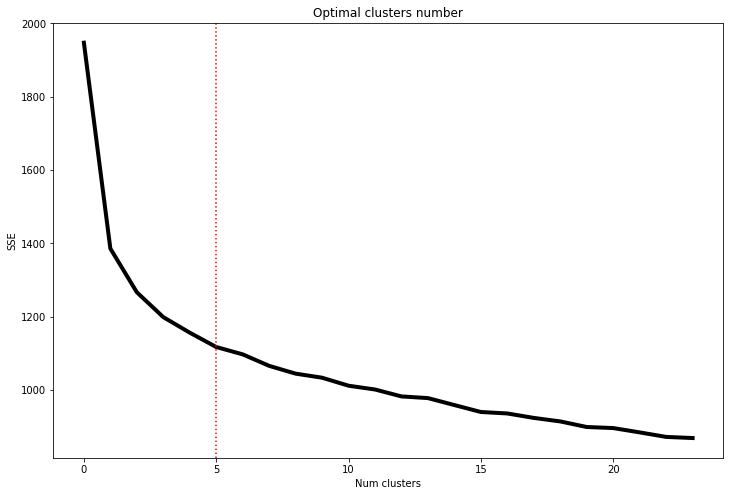

In [6]:
# use the "elbow-method" to evaluate the find number of clusters based on the SSE of the clustering
n_clusters = 5  # the value 5 was decided by eye based on the plot below
sse = []
for k in np.arange(1, 25):
    km = TimeSeriesKMeans(n_clusters=k, max_iter=100, metric="euclidean", n_jobs=-1, n_init=5).fit(Z)
    sse.append(km.inertia_)

f, ax = plt.subplots(figsize=(12, 8))

ax.plot(sse, lw=4, color="black")
ax.axvline(n_clusters, color="red", ls=":")
_ = ax.set(xlabel="Num clusters", ylabel="SSE", title="Optimal clusters number")


### Clustering
Do the clustering with the number of clusters decided above, and show the "representative" trace of each cluster alongside the traces of all units in the cluster.

In addition, compute the average activity in th baseline and post-movement onset periods to identify clusters that correspond to significant modulations in activity.

Finally, for clusters that show a significant modulation, get the timing based on the change in the representative trace compared to baseline.

/opt/miniconda3/envs/apa/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 304 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


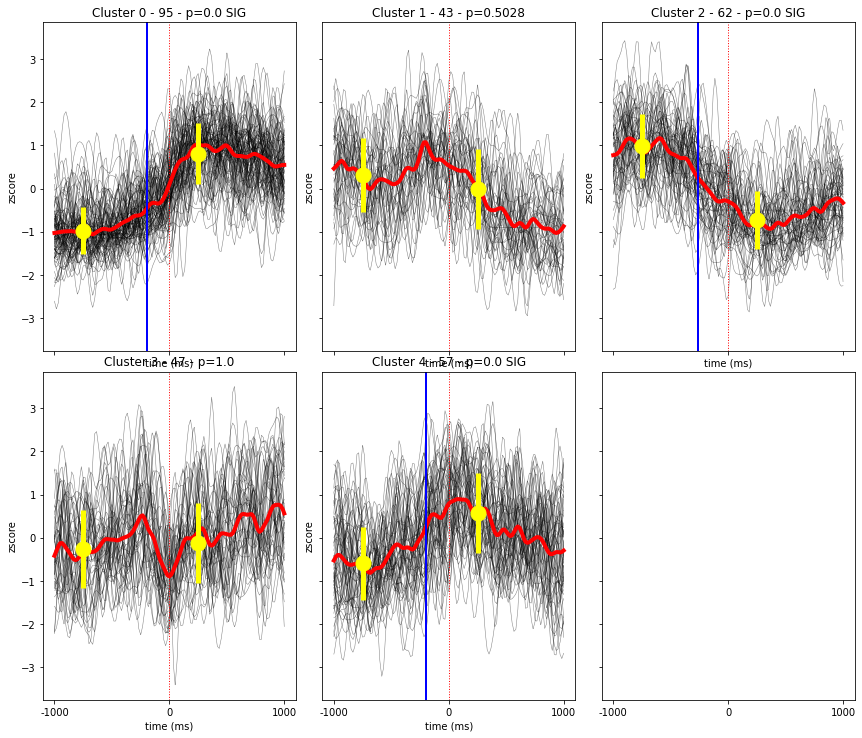

In [7]:
window = 500 # basleine: from -DeltaT to -DeltaT+window, post mvmt from 0 to window
onset_deltas = 1  # fraction of std above which a transient is considered

cluster_info = dict(
    id=[],
    sig=[],  # if change between baseline and post mvt activity is significant
    direction = [],  # activity increase/decrease
    onset_time_ms = [],  # timing in activity change compare to baseline
    n_units = [],   # in cluter
    unit_perc = [],  # percentage of units in cluster
)


# K-means clustering
km = TimeSeriesKMeans(n_clusters=n_clusters, max_iter=250, metric="euclidean", n_jobs=-1, n_init=10).fit(Z)
representatives = km.cluster_centers_[:, :, 0]
transformed = km.predict(Z)

nrows, ncols = calc_nrows_ncols(n_clusters, aspect=(12, 10))
f, axes = plt.subplots(nrows, ncols, figsize=(12, 10), sharex=True, sharey=True)
axes = axes.flatten()
f.tight_layout()

# plot individual traces
baselines, post_movement = {l:[] for l in range(n_clusters)}, {l:[] for l in range(n_clusters)}  # store activity in the baseline and post movement periods
for i, label in enumerate(transformed):
    axes[label].plot(Z[i, :], lw=0.5, color="black", alpha=.5)

    # store baseline/mvmt traces
    baselines[label].append(Z[i, :window])
    post_movement[label].append(Z[i, DeltaT:DeltaT+window])

# plot cluster candidate trace
for i in np.arange(0, n_clusters):
    axes[i].plot(representatives[i, :], lw=4, color="red")
    axes[i].set( 
            xticks=[0, DeltaT, 2*DeltaT], 
            xticklabels=[-DeltaT, 0, DeltaT], 
            xlabel="time (ms)", ylabel="zscore"
    )
    axes[i].axvline(DeltaT, lw=1, color="red", ls=":")


# plot average and std of baseline/movement periods
pvals = []
for i in np.arange(0, n_clusters):
    b, m = np.vstack(baselines[i]), np.vstack(post_movement[i])
    mu_b, mu_m = np.mean(b), np.mean(m)

    _, p = ttest_ind_from_stats(
    np.mean(b), np.std(b), len(b),
    np.mean(m), np.std(m), len(m),
)
    # _, p = ttest_ind(np.mean(b), np.mean(m), np.std(b), np.std(m))
    pvals.append(p)
   
    axes[i].errorbar(
        [window/2, DeltaT+window/2], 
        [mu_b, mu_m],  
        yerr=[np.std(b), np.std(m)], 
        lw=5, color="yellow", fmt="o", zorder=60, markersize=15)


# do bonf corr for pvalues then analyze significant
rejected, p_corrected, _, _ = smm.multipletests(pvals, alpha=0.05, method='bonferroni')
for i, (sig, p) in enumerate(zip(rejected, p_corrected)):
    cluster_info["id"].append(i)


    n_in_clust = len(np.where(transformed == i)[0])
    cluster_info["n_units"].append(n_in_clust)
    cluster_info["unit_perc"].append(n_in_clust / len(transformed) * 100)

    val = f"p={round(p, 6)}" + (" SIG" if sig else "")
    axes[i].set(title=f"Cluster {i} - {len(np.where(transformed == i)[0])} - {val}")

    # get the timing of change onset
    b, m = np.vstack(baselines[i]), np.vstack(post_movement[i])
    mu_b, mu_m = np.mean(b), np.mean(m)
    if sig:
        cluster_info["sig"].append(True)
        if mu_b > mu_m:
            # activity decreases
            th = mu_b - onset_deltas*(np.std(b))
            onset = np.where(representatives[i, :] < th)[0][0]
            cluster_info["direction"].append("decrease")
        else:
            # activity increases
            th = mu_b + onset_deltas*(np.std(b))
            onset = np.where(representatives[i, :] > th)[0][0]
            cluster_info["direction"].append("increase")
        cluster_info["onset_time_ms"].append(-(DeltaT - onset))

        axes[i].axvline(onset, lw=2, color="blue")
    else:
        cluster_info["sig"].append(False)
        cluster_info["direction"].append("-")
        cluster_info["onset_time_ms"].append("-")

In [8]:
# print cluster info
cluster_info = pd.DataFrame(cluster_info)
print(cluster_info)


   id    sig direction onset_time_ms  n_units  unit_perc
0   0   True  increase          -191       95  31.250000
1   1  False         -             -       43  14.144737
2   2   True  decrease          -264       62  20.394737
3   3  False         -             -       47  15.460526
4   4   True  increase          -197       57  18.750000


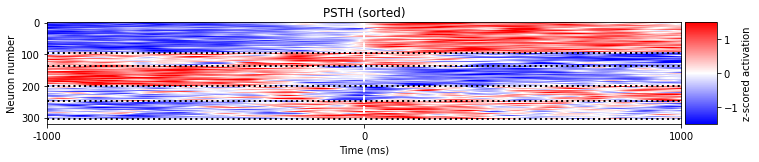

In [9]:
# replot heatmap of all PSTH, but sorting units by their cluster ID

# get the number of cells in each clusters
n = [len(np.where(transformed == i)[0]) for i in range(n_clusters)]
demarcators = np.cumsum(n)

Z_sorted = Z[np.argsort(transformed), :]
f, ax = plt.subplots(figsize=(12, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(Z_sorted, cmap="bwr", clim=[-1.5, 1.5])
f.colorbar(im, cax=cax, orientation='vertical', label="z-scored activation")
ax.axvline(DeltaT, lw=2, color="white", ls="--")

for dm in demarcators:
    ax.axhline(dm, lw=2, color="black", ls=":")

_ = ax.set(xlabel="Time (ms)", xticks=[0, DeltaT, 2*DeltaT], xticklabels=[-DeltaT, 0, DeltaT], ylabel="Neuron number", title="PSTH (sorted)")


### Identify significant clusters
Some clusters will correspond to no significant modulation. Find clusters whose "representative" indicates significant peri-stimulus modulation.